In [16]:
import glob
import pickle
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string

from typing import List

from mlxtend.evaluate import cochrans_q

In [17]:
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans serif")
# sns.set_palette(['#9e0059', '#6da7de', '#ee266d', '#dee000', '#eb861e'])
sns.set_context("paper", font_scale=1.3)

width = 7
height = width / 1.618

/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_49864/243690327.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-white", "seaborn-paper"])
/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_49864/243690327.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-white", "seaborn-paper"])


In [18]:
def top_k_retrieval_accuracy(retrieval_files: List[str], max_k=200):

    # Extract rankings from file
    ret_results = {}
    for file in retrieval_files:
        with open(file, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]

            seed = file.split("/")[4].replace("ablation_retrieval", "")
            model = file.split("/")[5].replace("contrast_", "")
            ret_results[(model, seed)] = (names, ind_found)

    # Calc common inds and subset
    common_inds = None
    for i, j in ret_results.values():
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    results_masked = {}
    for key, (ret_name, ret_ind) in ret_results.items():
        mask = [i in common_inds for i in ret_name]
        results_masked[key] = (ret_name[mask], ret_ind[mask])
    ret_results = results_masked

    # Create top k
    top_k_results = {}
    k_vals = np.arange(0, max_k)
    # max_k = np.max(k_vals) + 1
    for key, (ret_name, ret_ind) in ret_results.items():
        top_k_x, top_k_y = [], []
        for k in k_vals:
            top_k_x.append(k)
            top_k_y.append(np.mean(ret_ind <= k))
        top_k_results[key] = (np.array(top_k_x), np.array(top_k_y))

    return top_k_results

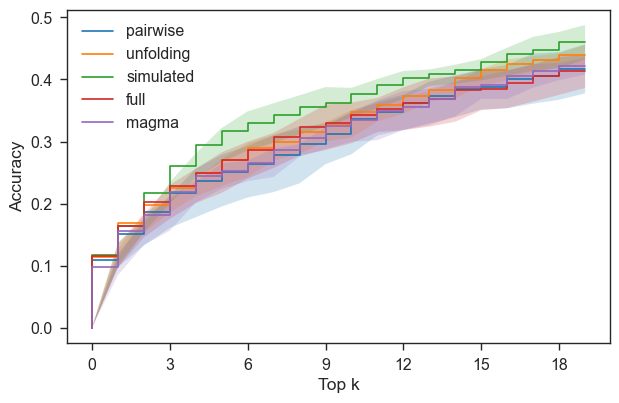

In [19]:
all_ret_files = glob.glob(
    "../../results/ablation/ablation_models*/**/merged_retrieval/*ind_found.p"
)

top_k_results = top_k_retrieval_accuracy(all_ret_files, max_k=20)
ablation_models = list(set([i[0] for i in list(top_k_results.keys())]))
top_k_avg = {}
for model in ablation_models:
    model_results = []
    for key, (x, y) in top_k_results.items():

        if key[0] == model:
            model_results.append(y)
    mean = np.mean(model_results, axis=0)
    std = np.std(model_results, axis=0)
    top_k_avg[model] = (x, mean, std)

# Plot
fig = plt.figure(figsize=(width, height))
for model, (x, avg, std) in top_k_avg.items():
    plt.step(x, avg, label=model)
    plt.fill_between(x, avg - std, avg + std, alpha=0.2)

plt.legend()
plt.xlabel("Top k")
plt.ylabel("Accuracy")
fig.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

{('pairwise', 5): [0.22857142857142856, 0.2357142857142857, 0.19285714285714287, 0.15714285714285714, 0.2714285714285714], ('pairwise', 20): [0.42142857142857143, 0.45714285714285713, 0.42142857142857143, 0.34285714285714286, 0.44285714285714284], ('unfolding', 5): [0.22142857142857142, 0.22857142857142856, 0.25, 0.20714285714285716, 0.22142857142857142], ('unfolding', 20): [0.4642857142857143, 0.44285714285714284, 0.44285714285714284, 0.4142857142857143, 0.4357142857142857], ('simulated', 5): [0.2714285714285714, 0.29285714285714287, 0.2357142857142857, 0.25, 0.2571428571428571], ('simulated', 20): [0.4642857142857143, 0.5071428571428571, 0.45, 0.45714285714285713, 0.42142857142857143], ('full', 5): [0.2357142857142857, 0.25, 0.2642857142857143, 0.2, 0.19285714285714287], ('full', 20): [0.42142857142857143, 0.38571428571428573, 0.45714285714285713, 0.38571428571428573, 0.4142857142857143], ('magma', 5): [0.25, 0.20714285714285716, 0.20714285714285716, 0.22142857142857142, 0.2071428571

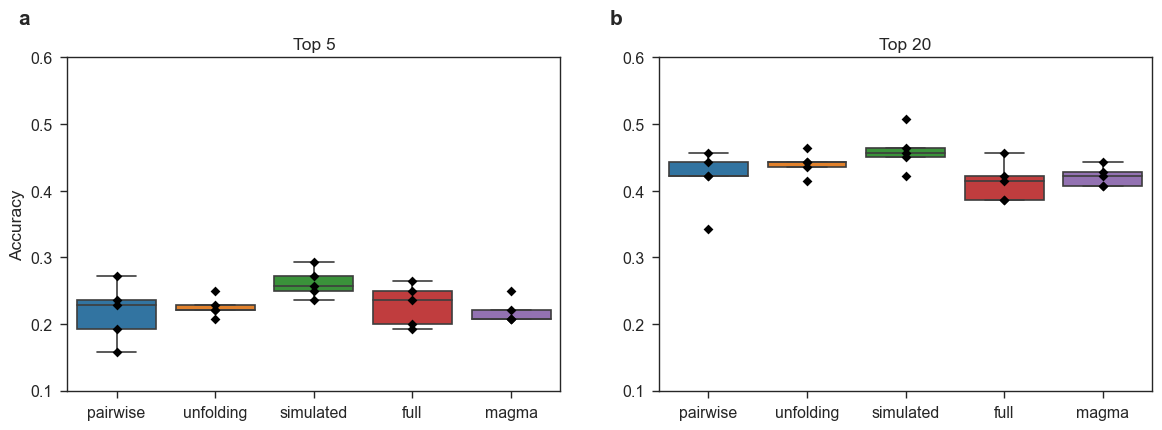

In [20]:
# boxplot at k=5 and k=20
k_values = [5, 20]
top_k_results = top_k_retrieval_accuracy(all_ret_files, max_k=20)
ablation_models = list(set([i[0] for i in list(top_k_results.keys())]))
top_k_values = {}
for model in ablation_models:
    for key, (x, y) in top_k_results.items():
        if key[0] == model:
            for k in k_values:
                if (model, k) not in top_k_values:
                    top_k_values[(model, k)] = [y[k - 1]]
                else:
                    top_k_values[(model, k)].append(y[k - 1])
print(top_k_values)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(width * 2, height))
for i, k in enumerate(k_values):
    plot_data = {
        key[0]: value for key, value in top_k_values.items() if key[1] == k
    }
    plot_df = pd.DataFrame(plot_data)
    plot_df = plot_df.melt(var_name="model", value_name="accuracy")

    sns.boxplot(
        data=plot_df, x="model", y="accuracy", ax=axes[i], showfliers=False
    )
    sns.stripplot(
        data=plot_df,
        x="model",
        y="accuracy",
        ax=axes[i],
        jitter=False,
        color="black",
        marker="D",
    )

    axes[i].set_title(f"Top {k}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_ylim(0.1, 0.6)

    axes[i].text(
        -0.1,
        1.1,
        string.ascii_lowercase[i],
        transform=axes[i].transAxes,
        size=15,
        weight="bold",
    )

axes[0].set_ylabel("Accuracy")

save_name = "../../results/ablation/ablation_retrieval_box.pdf"
plt.savefig(
    save_name, format="pdf", bbox_inches="tight", dpi=600, transparent=True
)

### Cochran's Q test

In [27]:
# get ranks of median model at k=5 and k=20
median_models = {}
for k in k_values:

    median_ranking_files = []
    for model in ablation_models:
        # get model that has median accuracy
        median = np.median(top_k_values[(model, k)])
        models = [
            (key[1], value[1][k - 1])
            for key, value in top_k_results.items()
            if key[0] == model
        ]
        median_model = [key for key, value in models if value == median][
            0
        ]  # seed value
        median_models[model, k] = (median_model, median)
        # print(f"Median model for {model} at k={k} is seed {median_model}")

        # get ranking file of median model
        median_model_file = [
            file
            for file in all_ret_files
            if model in file and median_model in file
        ][0]
        median_ranking_files.append(median_model_file)
        # print(f"Median model file: {median_model_file}")

    ret_results = {}
    for file in median_ranking_files:
        with open(file, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]
            seed = file.split("/")[4].replace("ablation_retrieval", "")
            model = file.split("/")[5].replace("contrast_", "")
            ret_results[(model, seed)] = (names, ind_found)

    # Calc common inds and subset
    common_inds = None
    for i, j in ret_results.values():
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    results_masked = {}
    for key, (ret_name, ret_ind) in ret_results.items():
        mask = [i in common_inds for i in ret_name]
        results_masked[key] = (ret_name[mask], ret_ind[mask])
    ret_results = results_masked

    # print(ret_results)

    # get correct predictions
    pred_results = {}
    for key, (ret_name, ret_ind) in ret_results.items():
        pred_results[key] = (ret_ind <= 5).astype(int)
    # print(pred_results)

    # cochran's Q test
    y_true = np.array([1] * len(list(pred_results.values())[0]))
    y_preds = np.array(list(pred_results.values()))

    q, p = cochrans_q(y_true, *y_preds)
    print(f"Cochran's Q test for k={k}: Q={q:.3f}, p={p:.3f}")
# print(median_models)

Cochran's Q test for k=5: Q=7.656, p=0.105
Cochran's Q test for k=20: Q=4.311, p=0.366
